In [54]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn import svm
from sklearn.metrics import *
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from ipynb.fs.full.Performance_Utilities import calculate_optimal_threshold, print_metrics
from utils.create_features_utils import *
from sklearn.base import clone
import os

In [2]:
df = pd.read_csv('data/wimbledon_matches_with_feature.csv')
raw_tennis_file = "data/mens/combined_raw_data.csv"
round_16_file = "data/wimbledon_2019.csv"

In [3]:
round_16 = pd.read_csv(round_16_file) # Round of 16 and on from Wimbledon 2019
raw_tennis = pd.read_csv(raw_tennis_file) # Raw tennis file

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
features_list = [
 'diff_rank',
 'diff_match_win_percent',
 'diff_games_win_percent',
 'diff_5_set_match_win_percent',
 'diff_close_sets_percent',
 'diff_match_win_percent_grass',
 'diff_games_win_percent_grass',
 'diff_5_set_match_win_percent_grass',
 'diff_close_sets_percent_grass',
 'diff_match_win_percent_52',
 'diff_games_win_percent_52',
 'diff_5_set_match_win_percent_52',
 'diff_close_sets_percent_52',
 'diff_match_win_percent_grass_60',
 'diff_games_win_percent_grass_60',
 'diff_5_set_match_win_percent_grass_60',
 'diff_close_sets_percent_grass_60',
 'diff_match_win_percent_hh',
 'diff_games_win_percent_hh',
 'diff_match_win_percent_grass_hh',
 'diff_games_win_percent_grass_hh']

In [5]:
df = df.dropna()

df['diff_rank'] = df['player_0_rank'] - df['player_1_rank']

In [6]:
# Train-test split
y = df.outcome
X = df[features_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, shuffle=True, test_size=0.20)

In [7]:
# Final to predict on
round_16['Date'] = '2019/07/07'
round_16['Surface'] = 'Grass'
round_16['diff_rank'] = round_16['player_0_rank'] - round_16['player_1_rank']

wimby_2019 = create_features(round_16, raw_tennis) # Round 16 and on Wimby 2019
X_wimby_2019 = wimby_2019[features_list]

Creating Player Career Stats All Surface
Creating Player Career Stats on Grass/Clay/Hard
Creating Player Career Stats All Surface Last 52 Weeks
Creating Player Career Stats on Grass/Clay/Hard Last 60 Weeks
Creating Player Head to Head Career Stats All Surface
Creating Player Head to Head Career Stats On Grass
Creating Difference Variables


In [84]:
grid_params = [{"C": [1, 1.5, 2, 2.5, 3, 3.5, 4], "gamma": [.05, .1, .15, .2, .25, .3, .4, .5]}]

In [89]:
svm_model = svm.SVC(C = 3.5, gamma = .05, probability=True, kernel = "rbf")
svm_model.fit(X_train, y_train)

SVC(C=3.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [86]:
grid_search_svm = GridSearchCV(estimator = svm_model, param_grid = grid_params, scoring = 'roc_auc', cv = 5)

In [87]:
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=3, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3, gamma=0.05,
                           kernel='rbf', max_iter=-1, probability=True,
                           random_state=None, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 1.5, 2, 2.5, 3, 3.5, 4],
                          'gamma': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4,
                                    0.5]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [88]:
grid_search_svm.best_params_

{'C': 3.5, 'gamma': 0.05}

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


,Model,Accuracy,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Sensitivity,Specificity,AUC,F1-Score,Geometric Mean,Kappa-Statistics,Sklearn Version
0,SVM,0.718,0.115,0.95,0.05,0.885,0.115,0.95,0.626,0.184,0.331,0.084,0.22


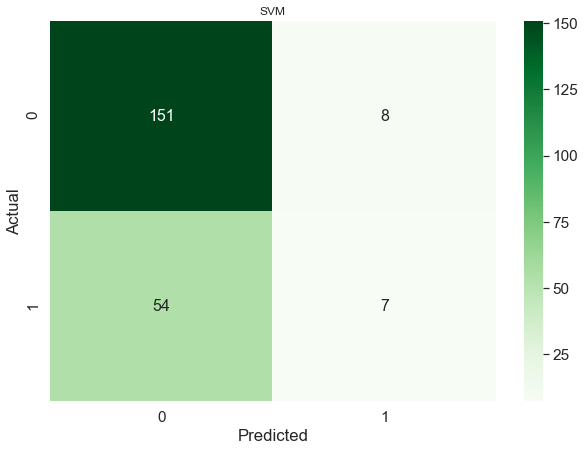

In [90]:
print_metrics(X_test, y_test, svm_model, "SVM")[1]